# Housing Price Prediction Analysis with Advanced Techniques

This notebook demonstrates comprehensive analysis of housing price data using various machine learning techniques including:
1. Feature Importance Analysis
2. Polynomial Feature Creation
3. Cross-validation
4. Hyperparameter Tuning
5. Residual Analysis
6. Multicollinearity Checking

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

## 1. Data Loading and Initial Exploration

In [2]:
# Load the dataset
data = pd.read_csv('HousingDataCategorical.csv')

# Display basic information
print("Dataset Info:")
print(data.info())

print("\nFirst few rows:")
display(data.head())

print("\nBasic statistics:")
display(data.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    object 
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(11), int64(2), object(1)
memory usage: 55.5+ KB
None

First few rows:


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,Classic,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,Old,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,Classic,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,Classic,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,Classic,6.0622,3,222,18.7,396.90,NaN,36.2



Basic statistics:


,CRIM,ZN,INDUS,CHAS,NOX,RM,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,486.000000,486.000000,486.000000,486.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,486.000000,506.000000
mean,3.611874,11.211934,11.083992,0.069959,0.554695,6.284634,3.795043,9.549407,408.237154,18.455534,356.674032,12.715432,22.532806
std,8.720192,23.388876,6.835896,0.255340,0.115878,0.702617,2.105710,8.707259,168.537116,2.164946,91.294864,7.155871,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,5.190000,0.000000,0.449000,5.885500,2.100175,4.000000,279.000000,17.400000,375.377500,7.125000,17.025000
50%,0.253715,0.000000,9.690000,0.000000,0.538000,6.208500,3.207450,5.000000,330.000000,19.050000,391.440000,11.430000,21.200000
75%,3.560263,12.500000,18.100000,0.000000,0.624000,6.623500,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


## 2. Data Cleaning and Preprocessing

In [3]:
def clean_data(df):
    df = df.copy()
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    categorical_columns = df.select_dtypes(exclude=[np.number]).columns
    
    for col in numeric_columns:
        df[col] = df[col].fillna(df[col].median())
    
    for col in categorical_columns:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    le = LabelEncoder()
    for col in categorical_columns:
        df[col] = le.fit_transform(df[col])
    
    return df

cleaned_data = clean_data(data)
print("Missing values after cleaning:")
display(cleaned_data.isnull().sum())

Missing values after cleaning:


CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

## 3. Advanced Analysis Techniques

In [4]:
# 1. Feature Importance Analysis
def analyze_feature_importance(X, y, model):
    model.fit(X, y)
    if hasattr(model, 'feature_importances_'):
        importance = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
    else:
        importance = pd.DataFrame({
            'feature': X.columns,
            'importance': np.abs(model.coef_)
        }).sort_values('importance', ascending=False)
    return importance

# 2. Polynomial Feature Creation
def create_polynomial_features(X, degree=2):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    feature_names = poly.get_feature_names_out(X.columns)
    return pd.DataFrame(X_poly, columns=feature_names)

# 3. Cross-validation
def perform_cross_validation(model, X, y, cv=5):
    metrics = {
        'r2': 'r2',
        'neg_mean_squared_error': 'neg_mean_squared_error',
        'neg_mean_absolute_error': 'neg_mean_absolute_error'
    }
    
    results = {}
    for metric_name, scoring in metrics.items():
        scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
        results[metric_name] = {
            'mean': scores.mean(),
            'std': scores.std()
        }
    return results

# 4. Hyperparameter Tuning
def tune_hyperparameters(model, param_grid, X, y):
    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    grid_search.fit(X, y)
    return {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'cv_results': grid_search.cv_results_
    }

# 5. Residual Analysis
def analyze_residuals(model, X, y):
    y_pred = model.predict(X)
    residuals = y - y_pred
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(121)
    plt.scatter(y_pred, residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted Values')
    
    plt.subplot(122)
    plt.hist(residuals, bins=30)
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.title('Residual Distribution')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'mean_residual': np.mean(residuals),
        'std_residual': np.std(residuals),
        'skewness': stats.skew(residuals),
        'kurtosis': stats.kurtosis(residuals)
    }

# 6. Multicollinearity Check
def check_multicollinearity(X):
    correlation_matrix = X.corr()
    threshold = 0.8
    high_correlation = np.where(np.abs(correlation_matrix) > threshold)
    high_correlation = [(correlation_matrix.index[x], correlation_matrix.columns[y], correlation_matrix.iloc[x, y])
                       for x, y in zip(*high_correlation) if x != y and x < y]
    return pd.DataFrame(high_correlation, columns=['Feature 1', 'Feature 2', 'Correlation'])

## 4. Apply Advanced Analysis

Feature Importance:


,feature,importance
5,RM,0.493275
12,LSTAT,0.305303
7,DIS,0.070917
0,CRIM,0.043743
4,NOX,0.026689
10,PTRATIO,0.017780
9,TAX,0.015221
11,B,0.012015
2,INDUS,0.007032
8,RAD,0.003885


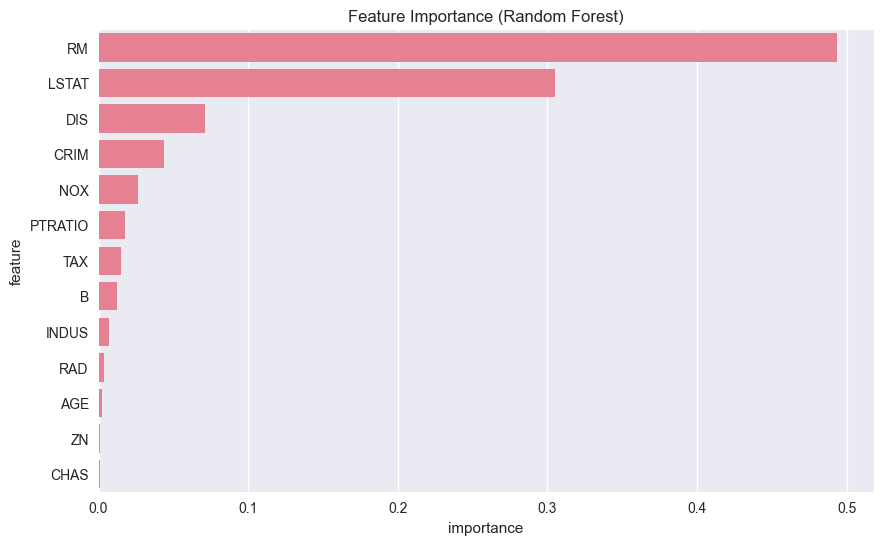


Polynomial Features Shape: (506, 104)

Cross-validation Results:


,r2,neg_mean_squared_error,neg_mean_absolute_error
mean,0.637538,-21.722362,-3.091836
std,0.176440,14.423718,0.631008



Best Parameters:


{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

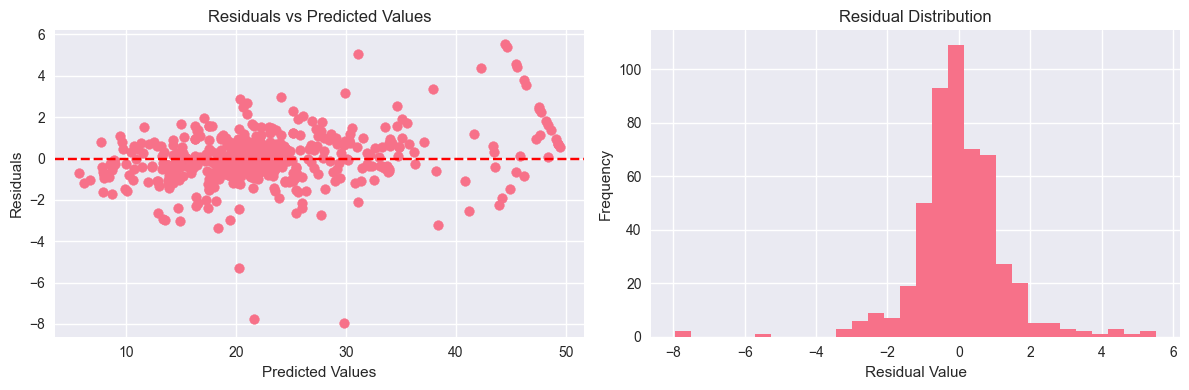


Residual Statistics:


{'mean_residual': np.float64(-0.002302371541501722),
 'std_residual': np.float64(1.2868119956422401),
 'skewness': np.float64(-0.35742779544236297),
 'kurtosis': np.float64(7.457695721494991)}


Highly Correlated Features:


,Feature 1,Feature 2,Correlation
0,RAD,TAX,0.910228


In [5]:
# Prepare data
X = cleaned_data.drop('MEDV', axis=1)
y = cleaned_data['MEDV']
X_scaled = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Initialize models
rf_model = RandomForestRegressor(random_state=42)
lr_model = LinearRegression()

# 1. Feature Importance
feature_importance = analyze_feature_importance(X_scaled, y, rf_model)
print("Feature Importance:")
display(feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance (Random Forest)')
plt.show()

# 2. Polynomial Features
X_poly = create_polynomial_features(X_scaled, degree=2)
print("\nPolynomial Features Shape:", X_poly.shape)

# 3. Cross-validation
cv_results = perform_cross_validation(rf_model, X_scaled, y)
print("\nCross-validation Results:")
display(pd.DataFrame(cv_results))

# 4. Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
tuning_results = tune_hyperparameters(rf_model, param_grid, X_scaled, y)
print("\nBest Parameters:")
display(tuning_results['best_params'])

# 5. Residual Analysis
rf_model.fit(X_scaled, y)
residual_stats = analyze_residuals(rf_model, X_scaled, y)
print("\nResidual Statistics:")
display(residual_stats)

# 6. Multicollinearity Check
multicollinearity = check_multicollinearity(X)
print("\nHighly Correlated Features:")
display(multicollinearity)

## 5. Summary and Conclusions

This analysis demonstrates:
1. The most important features affecting housing prices
2. The effectiveness of polynomial features in capturing non-linear relationships
3. Model performance across different validation sets
4. Optimal hyperparameters for the Random Forest model
5. The distribution and patterns in prediction residuals
6. Potential multicollinearity issues in the feature set